# <font style="color:blue">Train DensePose with detectron2</font>

In this module, we will go through the training of densepose using detectron2. Here, we will use COCO dataset with densepose annotations.

## <font style="color:green">1. Setup Code</font>

To use the detectron2's densepose training module, we will setup the detectron2 code.

In [1]:
!git clone https://github.com/facebookresearch/detectron2.git

Cloning into 'detectron2'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 5058 (delta 0), reused 1 (delta 0), pack-reused 5050
Receiving objects: 100% (5058/5058), 2.46 MiB | 1.71 MiB/s, done.
Resolving deltas: 100% (3620/3620), done.
Checking connectivity... done.


**Note**: We need to make a change in `densepose_coco_evaluation.py` so that later in densepose evaluations, the `unused arguments timeout` error is fixed. This needs no arguments to be passed other than path in the line number 143.
```
pdist_matrix_fpath = PathManager.get_local_path(
            "https://dl.fbaipublicfiles.com/densepose/data/Pdist_matrix.pkl", timeout_sec=120
        )
```
to be changed to
```
pdist_matrix_fpath = PathManager.get_local_path(
            "https://dl.fbaipublicfiles.com/densepose/data/Pdist_matrix.pkl"
        )
```

In [2]:
%cd detectron2/projects/DensePose

/data-ssd-4tb-b/prakash/densepose/Densepose/detectron2/projects/DensePose


## <font style="color:green">2. Dataset Preparation</font>

Here, we downloaded 2014 val Images from <a href="http://cocodataset.org/#download">COCO website</a>. We have chosen val images (`6GB`) instead of train images (`13GB`) as it is smaller in size.

**[Download the COCO val2014 Dataset](http://images.cocodataset.org/zips/val2014.zip)**

After downloading the COCO val2014 dataset, unzip it in the current directory. 

And the annotation files can be downloaded from <a href="https://github.com/facebookresearch/DensePose/blob/master/DensePoseData/get_DensePose_COCO.sh">here</a>.


From the annotations, it is found the number of images with annotations from val set are 1500. From these images, we will use 1000 images for creating train, val and test datasets.

Train, val and test datasets will follow the structure given in the detectron2 training module.

```
datasets
|
|-->coco
       |
       |-->annotations
       |       |-->densepose_train2014.json
       |       |-->densepose_valminusminival2014.json
       |       |-->densepose_minival2014.json
       |
       |-->train2014
       |
       |-->val2014
```

Script for splitting the images and annotations into train, val and test can be found at **[GenerateDatasets.ipynb](https://www.dropbox.com/s/rio3wx75srgndal/GenerateDatasets.ipynb?dl=1)**.

In [3]:
import urllib

def download(url, filepath):
    response = urllib.request.urlretrieve(url, filepath)
    return response

Data and annotations zip folder can be downloaded from <a href="https://www.dropbox.com/s/biptqvnd7r35962/datasets.zip?dl=1">here</a>. Then we will unzip the folder following the same structure.

**[Download Prepared Dataset](https://www.dropbox.com/s/biptqvnd7r35962/datasets.zip?dl=1)**

**Let's download datsset and unzip it by running below code cells.**

In [4]:
prepared_data_link = 'https://www.dropbox.com/s/biptqvnd7r35962/datasets.zip?dl=1'
dataset_zip = 'datasets.zip'

download(prepared_data_link, dataset_zip)

('datasets.zip', <http.client.HTTPMessage at 0x7f7beae6fb50>)

In [5]:
import zipfile

def unzip(zip_filepath, target_dir):
    with zipfile.ZipFile(zip_filepath,'r') as zip_file:
        zip_file.extractall(target_dir)
    return

In [6]:
unzip(dataset_zip, ".")

In [1]:
# !ls datasets/coco/annotations

## <font style="color:green">3. Training</font>

### 3.1. Import Libraries

In [3]:
import logging
import os
from collections import OrderedDict

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import CfgNode, get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, hooks, launch
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, verify_results
from detectron2.modeling import DatasetMapperTTA
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer

In [4]:
from densepose import (
    DensePoseCOCOEvaluator,
    DensePoseGeneralizedRCNNWithTTA,
    add_dataset_category_config,
    add_densepose_config,
    load_from_cfg,
)
from densepose.data import DatasetMapper, build_detection_test_loader, build_detection_train_loader

### 3.2. Visualize Dataset

We will use detectron2's query_db.py to visualize the training dataset. 

- QueryDb is a tool to print or visualize DensePose data from a dataset. It has two modes: print and show to output dataset entries to standard output or to visualize them on images. Usage:
    - `python query_db.py print [-h] [-v] [--max-entries N] <dataset> <selector>`
    - `python query_db.py show [-h] [-v] [--max-entries N] [--output <image_file>] <dataset> <selector> <visualizations>`
    
There are three mandatory arguments:

- `<dataset>`, DensePose dataset specification, from which to select the entries (e.g. densepose_coco_2014_train).
- `<selector>`, dataset entry selector which can be a single specification, or a comma-separated list of specifications of the form field[:type]=value for exact match with the value or field[:type]=min-max for a range of values
- `<visualizations>`, visualizations specifier; currently available visualizations are:
    - bbox - bounding boxes of annotated persons;
    - dp_i - annotated points colored according to the containing part;
    - dp_pts - annotated points in green color;
    - dp_segm - segmentation masks for annotated persons;
    - dp_u - annotated points colored according to their U coordinate in part parameterization;
    - dp_v - annotated points colored according to their V coordinate in part parameterization;


In [4]:
!python query_db.py show densepose_coco_2014_train image_id:int=785 bbox,dp_i -v

[06/03 22:25:28 query_db]: Loading dataset densepose_coco_2014_train
[06/03 22:25:28 query_db]: Loaded dataset densepose_coco_2014_train in 0.370s
[06/03 22:25:28 query_db]: Output saved to output.0001.png


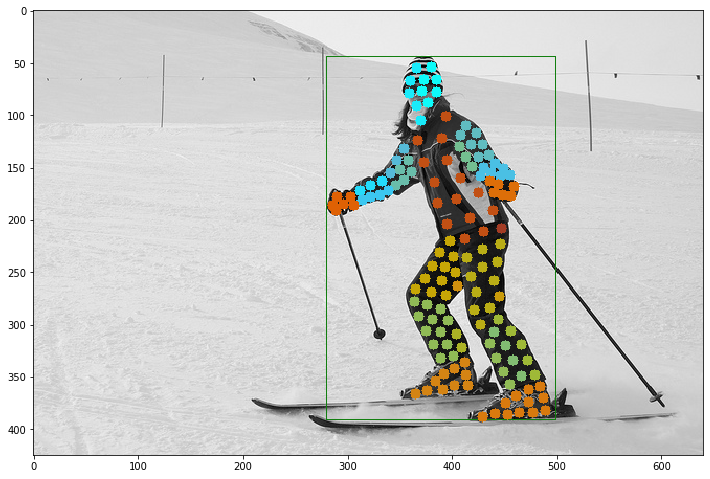

In [5]:
import cv2
import matplotlib.pyplot as plt

img =  cv2.imread("output.0001.png")
plt.figure(figsize = (12, 12))
plt.imshow(img)
plt.show()

### 3.3. Setup Config

- After using default config, densepose specific config is imported and dataset category config is added. More details of densepose specific config can be seen <a href="https://github.com/facebookresearch/detectron2/blob/master/projects/DensePose/densepose/config.py">here</a>.
- Following config options are passed as arguments  
    - Model config path
    - Batch size
    - Number of iterations
    - Learning rate
    - Number of workers
- freeze() makes cfgNode and all of its children immutable.
- Logger to be set for logs during training


In [5]:
def setup(args):
    cfg = get_cfg()
    add_dataset_category_config(cfg)
    add_densepose_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    default_setup(cfg, args)
    # Setup logger for "densepose" module
    setup_logger(output=cfg.OUTPUT_DIR, distributed_rank=comm.get_rank(), name="densepose")
    return cfg

### 3.4. Densepose Methods

- Evaluator
    - DenseposeCOCOEvaluator is added to the list of evaluators.
        - Similar to object detection's Intersection over Union(IOU) and keypoints' Object Keypoint Similarity(OKS) evaluation methods on COCO dataset, densepose uses Geodesic point similarity method for AP/AR calculation. GPS is based on geodesic distances on the template mesh between the collected groundtruth points and estimated surface coordinates for the same image points. More details can be found <a href="https://github.com/facebookresearch/DensePose/blob/master/challenge/2018_COCO_DensePose/evaluation.md">here</a>.
- DataLoaders
    - Uses custom datasetMapper to convert densepose data format to detectron2 format for data loading.
- Test Time Augmentation
    - Applies data Augmentation on test set during evaluation and runs inference on augmented data.

In [6]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg: CfgNode, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        evaluators = [COCOEvaluator(dataset_name, cfg, True, output_folder)]
        if cfg.MODEL.DENSEPOSE_ON:
            evaluators.append(DensePoseCOCOEvaluator(dataset_name, True, output_folder))
        return DatasetEvaluators(evaluators)

    @classmethod
    def build_test_loader(cls, cfg: CfgNode, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg: CfgNode):
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, True))

    @classmethod
    def test_with_TTA(cls, cfg: CfgNode, model):
        logger = logging.getLogger("detectron2.trainer")
        # In the end of training, run an evaluation with TTA
        # Only support some R-CNN models.
        logger.info("Running inference with test-time augmentation ...")
        transform_data = load_from_cfg(cfg)
        model = DensePoseGeneralizedRCNNWithTTA(cfg, model, transform_data, DatasetMapperTTA(cfg))
        evaluators = [
            cls.build_evaluator(
                cfg, name, output_folder=os.path.join(cfg.OUTPUT_DIR, "inference_TTA")
            )
            for name in cfg.DATASETS.TEST
        ]
        res = cls.test(cfg, model, evaluators)
        res = OrderedDict({k + "_TTA": v for k, v in res.items()})
        return res

### 3.5. Main function
- Above defained custom Trainer is initiated using above defined config.
- If the mode is evaluation only, Trainer loads the model, `DetectionCheckpointer` loads the model weights and evaluations on the cfg.TEST dataset, which is densepose_coco_minival2014 here.
- If test time augmentation is enabled, the additional evaluations are added to the previous evaluations.

In [7]:
def main(args):
    cfg = setup(args)

    if args.eval_only:
        model = Trainer.build_model(cfg)
        DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
            cfg.MODEL.WEIGHTS, resume=args.resume
        )
        res = Trainer.test(cfg, model)
        if cfg.TEST.AUG.ENABLED:
            res.update(Trainer.test_with_TTA(cfg, model))
        if comm.is_main_process():
            verify_results(cfg, res)
        return res

    trainer = Trainer(cfg)
    trainer.resume_or_load(resume=args.resume)
    if cfg.TEST.AUG.ENABLED:
        trainer.register_hooks(
            [hooks.EvalHook(0, lambda: trainer.test_with_TTA(cfg, trainer.model))]
        )
    return trainer.train()

**Uncomment the below code cell to install `attrdict`, if not already installed.**

In [14]:
# !pip install attrdict

In [8]:
from attrdict import AttrDict



if __name__ == "__main__":
    attr_dict = {'resume': False, 
                 'config_file':'configs/densepose_rcnn_R_50_FPN_s1x.yaml', 
                 'eval_only': False, 
                 'machine_rank': 0, 
                 'num_gpus': 2, 
                 'num_machines': 1, 
                 'opts': ['SOLVER.IMS_PER_BATCH', '4', 
                          'SOLVER.BASE_LR', '0.0005', 
                          'SOLVER.MAX_ITER', '200', 
                          'DATALOADER.NUM_WORKERS', '0']
                }


    args = AttrDict(attr_dict)


    main(args)

Config 'configs/densepose_rcnn_R_50_FPN_s1x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


[06/04 00:04:02 detectron2]: Rank of current process: 0. World size: 1
[06/04 00:04:03 detectron2]: Environment info:
----------------------  --------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0]
numpy                   1.17.2
detectron2              0.1.3 @/home/ubuntu/anaconda3/envs/pc_det/lib/python3.7/site-packages/detectron2
Compiler                GCC 5.4
CUDA compiler           9.2
detectron2 arch flags   sm_61
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.4.0+cu92 @/home/ubuntu/anaconda3/envs/pc_det/lib/python3.7/site-packages/torch
PyTorch debug build     False
CUDA available          True
GPU 0,1,2,3             GeForce GTX 1080 Ti
CUDA_HOME               /usr/local/cuda-9.2
Pillow                  6.2.0
torchvision             0.5.0+cu92 @/home/ubuntu/anaconda3/envs/pc_det/lib/python3.7/site-packages/torchvision
torchvision a

Pdist_matrix.pkl: 1.52GB [06:34, 3.85MB/s]                               

[06/04 00:16:56 fvcore.common.download]: Successfully downloaded /home/ubuntu/.torch/fvcore_cache/densepose/data/Pdist_matrix.pkl. 1518390904 bytes.
[06/04 00:16:56 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/densepose/data/Pdist_matrix.pkl cached in /home/ubuntu/.torch/fvcore_cache/densepose/data/Pdist_matrix.pkl


[06/04 00:19:19 densepose.densepose_coco_evaluation]: DensePose evaluation DONE (t=537.04s).
[06/04 00:19:19 densepose.densepose_coco_evaluation]: Accumulating evaluation results...
[06/04 00:19:19 densepose.densepose_coco_evaluation]: Categories: [1]
[06/04 00:19:19 densepose.densepose_coco_evaluation]: Final: max precision 0.0, min precision 0.0
[06/04 00:19:19 densepose.densepose_coco_evaluation]: DONE (t=0.01s).
[06/04 00:19:19 densepose.densepose_coco_evaluation]:  Average Precision  (AP) @[ OGPS=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
[06/04 00:19:19 densepose.densepose_coco_evaluation]:  Average Precision  (AP) @[ OGPS=0.50      | area=   all | maxDets= 20 ] = 0.000
[06/04 00:19:19 densepose.densepose_coco_evaluation]:  Average Precision  (AP) @[ OGPS=0.75      | area=   all | maxDets= 20 ] = 0.000
[06/04 00:19:19 densepose.densepose_coco_evaluation]:  Average Precision  (AP) @[ OGPS=0.50:0.95 | area=medium | maxDets= 20 ] = 0.000
[06/04 00:19:19 densepose.densepose_coco

/home/ubuntu/anaconda3/envs/pc_det/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


[06/04 00:23:23 densepose.densepose_coco_evaluation]: DensePose evaluation DONE (t=243.62s).
[06/04 00:23:23 densepose.densepose_coco_evaluation]: Accumulating evaluation results...
[06/04 00:23:23 densepose.densepose_coco_evaluation]: Categories: [1]
[06/04 00:23:23 densepose.densepose_coco_evaluation]: Final: max precision 0.0, min precision 0.0
[06/04 00:23:23 densepose.densepose_coco_evaluation]: DONE (t=0.01s).
[06/04 00:23:23 densepose.densepose_coco_evaluation]:  Average Precision  (AP) @[ OGPS=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
[06/04 00:23:23 densepose.densepose_coco_evaluation]:  Average Precision  (AP) @[ OGPS=0.50      | area=   all | maxDets= 20 ] = 0.000
[06/04 00:23:23 densepose.densepose_coco_evaluation]:  Average Precision  (AP) @[ OGPS=0.75      | area=   all | maxDets= 20 ] = 0.000
[06/04 00:23:23 densepose.densepose_coco_evaluation]:  Average Precision  (AP) @[ OGPS=0.50:0.95 | area=medium | maxDets= 20 ] = 0.000
[06/04 00:23:23 densepose.densepose_coco

Above, we have seen how the densepose can be trained using densepose. But to achieve better performance models in lesser time, we need to run the model on multiple gpus simultaneously with learning rate schedular. In demo, we have just used single gpu to show the process of training.

## <font style="color:green">References</font>

- https://github.com/facebookresearch/detectron2/blob/master/projects/DensePose/train_net.py
- https://detectron2.readthedocs.io/
- https://github.com/facebookresearch/DensePose